In [1]:
%load_ext autoreload
%autoreload
from representations_across_sizes.gride import calculate_gride_id, get_sequences
import torch

sequences_pile = get_sequences(dataset_name="pile")

In [2]:
len(sequences_pile[0])

10000

In [3]:
sequences_pile_debug = sequences_pile[0][:100]

In [4]:
sequences_pile_debug[:5]

["Q: Confluence wiki format put new paragraph I'd like to put empty linespace (<p></p> in HTML) in Confluence wiki result,",
 'but failed whatever I tried. Based on the the document, it said two carriage-return will put <p></p> but \\r\\r, \\n\\n,',
 '\\n\\n\\n\\n, etc.trials are not working at all. POST http://wiki.mysite.com/rest/api/content {"type":"page","title":"new page1","ancestors":[{"id":390668024}], "space":{"key":"EXAMPLE"},"body":{"storage":{"value":"[Some link|http://example.com/url] - Show page.\\n\\nbq. Query by [Some link',
 'info|http://example.com/reference?id=214]","representation":"wiki"}}} With above REST request, I\'d like to show as below format; Some link - Show page. <blank line> Query',
 'by Some link info Some trials (between words Show page. and bq. Query by) \\n\\n => Show page.</p>\\n\\n<blockquote><p>Query by \\\\\\\\']

In [5]:
%autoreload

from nnsight import LanguageModel

from representations_across_sizes.utils import get_activation_cache

model = "meta-llama/Llama-3.2-1B"
lm = LanguageModel(model, device_map="auto")
remote = False

activations = get_activation_cache(
    lm,
    layer_idxs=list(range(len(lm.model.layers))),
    dataset=sequences_pile_debug,
    llm_batch_size=64,
)


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


In [6]:
from lovely_tensors import monkey_patch

monkey_patch()
activations


{0: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-8.735, 23.898] μ=0.002 σ=0.106 cuda:0,
  tensor[36, 77, 2048] n=5677056 (22Mb) x∈[-8.735, 23.899] μ=0.002 σ=0.110 cuda:0],
 1: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-209.596, 217.685] μ=-0.000 σ=1.018 cuda:0,
  tensor[36, 77, 2048] n=5677056 (22Mb) x∈[-209.596, 217.684] μ=-0.001 σ=1.063 cuda:0],
 2: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-209.820, 217.937] μ=0.001 σ=1.021 cuda:0,
  tensor[36, 77, 2048] n=5677056 (22Mb) x∈[-209.819, 217.937] μ=0.001 σ=1.065 cuda:0],
 3: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-209.973, 218.084] μ=0.001 σ=1.022 cuda:0,
  tensor[36, 77, 2048] n=5677056 (22Mb) x∈[-209.972, 218.084] μ=0.001 σ=1.067 cuda:0],
 4: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-210.183, 218.381] μ=5.804e-06 σ=1.023 cuda:0,
  tensor[36, 77, 2048] n=5677056 (22Mb) x∈[-210.183, 218.381] μ=-0.000 σ=1.068 cuda:0],
 5: [tensor[64, 84, 2048] n=11010048 (42Mb) x∈[-210.460, 218.662] μ=-0.002 σ=1.025 cuda:0,
  tensor[36, 77, 2048] 

In [7]:
from typing import List
from torch import Tensor

# get only the last sequence, and cat into one tensor
for layer, acts in activations.items():
    acts: List[Tensor] = [act[:, -1, :] for act in acts]
    activations[layer] = torch.cat(acts, dim=0)

activations

{0: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.404, 0.546] μ=0.000 σ=0.037 cuda:0,
 1: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.734, 0.942] μ=0.001 σ=0.052 cuda:0,
 2: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.868, 1.544] μ=0.001 σ=0.069 cuda:0,
 3: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.254, 1.757] μ=0.001 σ=0.081 cuda:0,
 4: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.692, 1.838] μ=0.001 σ=0.091 cuda:0,
 5: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.879, 1.885] μ=0.001 σ=0.097 cuda:0,
 6: tensor[100, 2048] n=204800 (0.8Mb) x∈[-2.564, 1.245] μ=0.000 σ=0.102 cuda:0,
 7: tensor[100, 2048] n=204800 (0.8Mb) x∈[-3.272, 1.194] μ=-5.794e-06 σ=0.111 cuda:0,
 8: tensor[100, 2048] n=204800 (0.8Mb) x∈[-3.292, 1.404] μ=0.000 σ=0.125 cuda:0,
 9: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.083, 1.937] μ=-2.461e-05 σ=0.156 cuda:0,
 10: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.065, 2.164] μ=1.822e-05 σ=0.179 cuda:0,
 11: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.572, 3.065] μ=-0.000 σ=0.221 cuda:0,
 12: tensor

In [8]:
activations

{0: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.404, 0.546] μ=0.000 σ=0.037 cuda:0,
 1: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.734, 0.942] μ=0.001 σ=0.052 cuda:0,
 2: tensor[100, 2048] n=204800 (0.8Mb) x∈[-0.868, 1.544] μ=0.001 σ=0.069 cuda:0,
 3: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.254, 1.757] μ=0.001 σ=0.081 cuda:0,
 4: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.692, 1.838] μ=0.001 σ=0.091 cuda:0,
 5: tensor[100, 2048] n=204800 (0.8Mb) x∈[-1.879, 1.885] μ=0.001 σ=0.097 cuda:0,
 6: tensor[100, 2048] n=204800 (0.8Mb) x∈[-2.564, 1.245] μ=0.000 σ=0.102 cuda:0,
 7: tensor[100, 2048] n=204800 (0.8Mb) x∈[-3.272, 1.194] μ=-5.794e-06 σ=0.111 cuda:0,
 8: tensor[100, 2048] n=204800 (0.8Mb) x∈[-3.292, 1.404] μ=0.000 σ=0.125 cuda:0,
 9: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.083, 1.937] μ=-2.461e-05 σ=0.156 cuda:0,
 10: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.065, 2.164] μ=1.822e-05 σ=0.179 cuda:0,
 11: tensor[100, 2048] n=204800 (0.8Mb) x∈[-4.572, 3.065] μ=-0.000 σ=0.221 cuda:0,
 12: tensor

In [13]:
%load_ext autoreload
%autoreload

from collections import defaultdict

# gride
from representations_across_sizes.gride import calculate_gride_id


results = {}
for layer, acts in activations.items():
    ids_scaling, ids_scaling_err, rs_scaling = calculate_gride_id(acts.to("cpu"))
    results[layer] = ids_scaling.mean()


results


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found
No identical identical points were found


{0: 12.024991522681434,
 1: 17.208158848738353,
 2: 17.13428337949576,
 3: 20.111532379670702,
 4: 22.447636452184554,
 5: 21.729029671450263,
 6: 21.97781708537546,
 7: 21.56356680944658,
 8: 20.337681741257896,
 9: 18.161590252167105,
 10: 17.304295534299047,
 11: 16.002456403375138,
 12: 15.922735804278956,
 13: 15.69171966622447,
 14: 15.642085771761748,
 15: 13.427757388311699}

In [14]:
results[0].mean()

12.024991522681434

In [16]:
ids

{0: 12.024991522681434,
 1: 17.208158848738353,
 2: 17.13428337949576,
 3: 20.111532379670702,
 4: 22.447636452184554,
 5: 21.729029671450263,
 6: 21.97781708537546,
 7: 21.56356680944658,
 8: 20.337681741257896,
 9: 18.161590252167105,
 10: 17.304295534299047,
 11: 16.002456403375138,
 12: 15.922735804278956,
 13: 15.69171966622447,
 14: 15.642085771761748,
 15: 13.427757388311699}

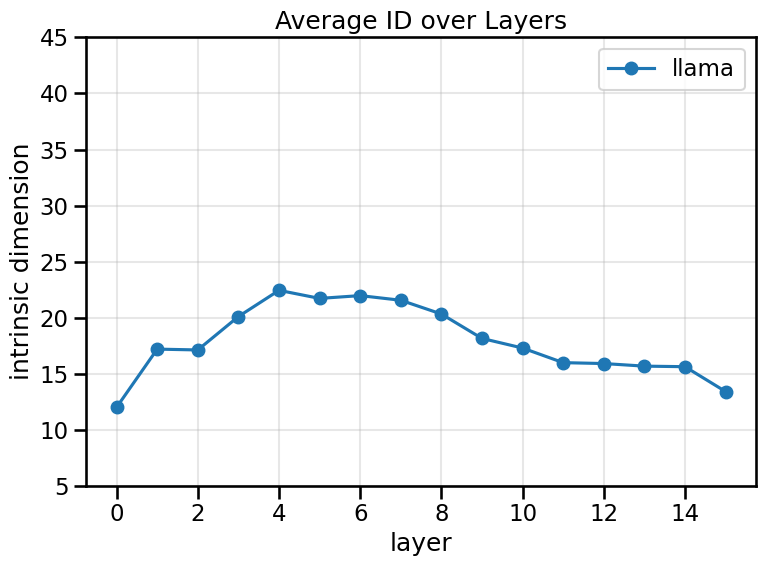

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_context("talk")
ids = np.array([v for v in results.values()])

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(
    ids, marker="o", label="llama", color="#1f77b4"
)  # Using the same blue as in reference

# Customize the plot
plt.title("Average ID over Layers")
plt.xlabel("layer")
plt.ylabel("intrinsic dimension")

# Add grid
plt.grid(True, alpha=0.3)

# Set y-axis limits similar to reference plot
plt.ylim(5, 45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


# for many models over all partitions

In [ ]:
from pathlib import Path
import json
import os
import dotenv

dotenv.load_dotenv()
RESULTS_DIR = Path(os.getenv("RESULTS_DIR"))


def get_id_results(dataset: List[str], model_name: str = "meta-llama/Llama-3.2-1B"):
    lm = LanguageModel(model, device_map="auto")

    activations = get_activation_cache(
        lm,
        layer_idxs=list(range(len(lm.model.layers))),
        dataset=dataset,
        llm_batch_size=64,
    )
    results = {}
    for layer, acts in activations.items():
        acts: List[Tensor] = [act[:, -1, :] for act in acts]
        activations[layer] = torch.cat(acts, dim=0)
        ids_scaling, ids_scaling_err, rs_scaling = calculate_gride_id(acts.to("cpu"))
        results[layer] = ids_scaling.mean()

    # Save results if path provided
    save_path = RESULTS_DIR / f"{model_name}.json"
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Save results with model name and timestamp
    from datetime import datetime

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_to_save = {
        "model": model_name,
        "timestamp": timestamp,
        "intrinsic_dimensions": results,
    }

    with open(save_path, "w") as f:
        json.dump(results_to_save, f, indent=2)
    return results

In [ ]:
import numpy as np

# use all partitions
sequences_pile = get_sequences(dataset_name="pile")

# Store IDs for each partition
all_partition_ids = []

for partition in sequences_pile:
    print(f"Processing partition {len(all_partition_ids) + 1}/5")

    # Get activations for this partition
    activations = get_activation_cache(
        lm,
        layer_idxs=list(range(len(lm.model.layers))),
        dataset=partition,
        llm_batch_size=64,
    )

    # Get only the last sequence token and calculate IDs
    for layer, acts in activations.items():
        acts = [act[:, -1, :] for act in acts]
        activations[layer] = torch.cat(acts, dim=0)

    # Calculate IDs for this partition
    partition_ids = [
        float(calculate_gride_id(activations[layer].to("cpu")))
        for layer in activations.keys()
    ]
    all_partition_ids.append(partition_ids)
    print(partition_ids)

# Convert to numpy for easier calculations
all_partition_ids = np.array(all_partition_ids)

# Calculate mean and std across partitions
mean_ids = np.mean(all_partition_ids, axis=0)
std_ids = np.std(all_partition_ids, axis=0)


In [ ]:
all_partition_ids[0]

In [ ]:
all_partition_ids[1]

In [ ]:
all_partition_ids[2]

In [ ]:
all_partition_ids[3]

In [ ]:
all_partition_ids[4]


In [ ]:
# Plot with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    range(len(mean_ids)),
    mean_ids,
    yerr=2 * std_ids,  # 2 standard deviations like in paper
    fmt="o-",
    label="llama",
    color="#1f77b4",
    capsize=3,
    markersize=4,
    linewidth=1,
    elinewidth=1,
)

# Customize the plot
plt.title("Average ID over Layers")
plt.xlabel("layer")
plt.ylabel("intrinsic dimension")

# Add grid
plt.grid(True, alpha=0.3)

# Set y-axis limits similar to reference plot
plt.ylim(5, 45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()